In [55]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


# TODO : 2020/09/07 현재 학습된 결과를 보지 못했다.

# 동 영상 영역분할

공개SW협회의 주관의 Open Up의 인공지능“이미지의 사물 검출에 딥러닝 활용(심화)”전문교육 프로그램중의 교재를 가져와서 수정함

https://edu.kosslab.kr/course/view.php?id=34


In [56]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import cv2

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model

# 데이터 준비

## 데이터 다운로드

http://www.robots.ox.ac.uk/~vgg/data/pets/ 의 데이터를 사용.

In [ ]:
%%shell
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2020-09-08 10:51:36--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  11.6MB/s    in 67s     

2020-09-08 10:52:44 (11.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2020-09-08 10:52:44--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  5.53MB/s    in 3.3s    

2020-09-08 10:52:48 (5.53 MB/s)

## 압축 풀기

In [ ]:
%%shell
tar -xvzf images.tar.gz
tar -xvzf annotations.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

In [ ]:
%%shell
rm -rf Lung_Segmentation
unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
   creating: Lung_Segmentation/
   creating: Lung_Segmentation/image/
  inflating: Lung_Segmentation/image/CHNCXR_0001_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0002_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0003_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0004_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0005_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0006_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0007_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0008_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0009_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0010_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0011_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0012_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0013_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0014_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0015_0.png  
  inflating: Lung_Segmentation/image/CHNCXR

## 불필요한 파일 삭제

In [ ]:
!rm images/*.mat
!rm annotations/trimaps/._*

## 깨진 파일 삭제

In [ ]:
%%shell
rm -f images/Egyptian_Mau_177.jpg
rm -f annotations/trimaps/Egyptian_Mau_177.png

rm -f images/Egyptian_Mau_191.jpg
rm -f annotations/trimaps/Egyptian_Mau_191.png

rm -f images/Egyptian_Mau_139.jpg
rm -f annotations/trimaps/Egyptian_Mau_139.png

rm -f images/Egyptian_Mau_145.jpg
rm -f annotations/trimaps/Egyptian_Mau_145.png

rm -f images/Egyptian_Mau_167.jpg
rm -f annotations/trimaps/Egyptian_Mau_167.png

rm -f images/Abyssinian_34.jpg
rm -f annotations/trimaps/Abyssinian_34.png

## 풀린 데이터 파일 구조

```
images/
  Abyssinian_1.jpg
  Abyssinian_10.jpg
  Abyssinian_100.jpg
  ...
annotations/
  trimaps/
    Abyssinian_1.png
    Abyssinian_10.png
    Abyssinian_100.png
    ...
  xmls/            # 사용한함.  PASCAL VOC Format의 object dtection 레이블
    Abyssinian_1.xml
    Abyssinian_10.xml
    Abyssinian_100.xml
    ...
  README           # 사용 안한
  list.txt         # 사용 안함
  test.txt         # 사용 안함
  trainval.txt     # 사용 안함
```

In [ ]:
%%shell
ls -al images/ | head
ls -al annotations/trimaps/ | head

total 788884
drwxr-xr-x 2 1001 1001  290816 Sep  8 10:54 .
drwxr-xr-x 1 root root    4096 Sep  8 10:53 ..
-rwxr-xr-x 1 1001 1001  126923 Jun 18  2012 Abyssinian_100.jpg
-rwxr-xr-x 1 1001 1001   49023 Jun 18  2012 Abyssinian_101.jpg
-rwxr-xr-x 1 1001 1001  165505 Jun 18  2012 Abyssinian_102.jpg
-rwxr-xr-x 1 1001 1001  132937 Jun 18  2012 Abyssinian_103.jpg
-rwxr-xr-x 1 1001 1001   34907 Jun 18  2012 Abyssinian_104.jpg
-rwxr-xr-x 1 1001 1001  141823 Jun 18  2012 Abyssinian_105.jpg
-rwxr-xr-x 1 1001 1001  197092 Jun 18  2012 Abyssinian_106.jpg
total 31112
drwxr-xr-x 2 501 staff 634880 Sep  8 11:09 .
drwxr-xr-x 4 501 staff   4096 Jun 30  2012 ..
-rwxr-xr-x 1 501 staff   3555 Jun 18  2012 Abyssinian_100.png
-rwxr-xr-x 1 501 staff   2468 Jun 18  2012 Abyssinian_101.png
-rwxr-xr-x 1 501 staff   3554 Jun 18  2012 Abyssinian_102.png
-rwxr-xr-x 1 501 staff   2791 Jun 18  2012 Abyssinian_103.png
-rwxr-xr-x 1 501 staff   3602 Jun 18  2012 Abyssinian_104.png
-rwxr-xr-x 1 501 staff   2521 Jun 18  20

## 파일 보기

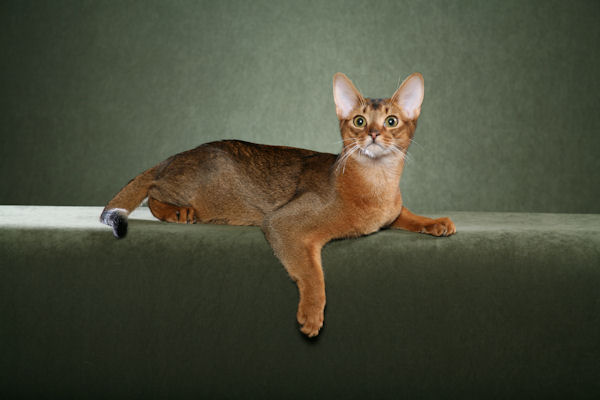

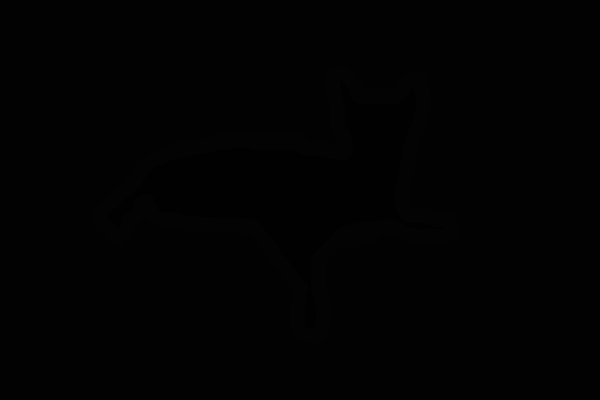

In [ ]:
from IPython.display import Image, display

display(Image('images/Abyssinian_1.jpg'))
display(Image('annotations/trimaps/Abyssinian_1.png'))


# ImageDataGenerator 선언

keras의 ImageDataGenerator를 사용하여 파일을 읽는다.

파일의 크기가 제각각이라 256x256 사이즈로 로딩한다.


batch_size를 파일 갯수 보다 큰 수로 두어 한번에 다 꺼내올 수 있도록 한다.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def normlaizize(image):
  return image/255.0

def binarize(mask):
  mask[ mask==1 ] = 1  # 전경(1)은 1로
  mask[ mask==2 ] = 0  # 배경(2)은 0으로
  mask[ mask==3 ] = 0  # 이외(3)도 0으로
  return mask


img_generator = ImageDataGenerator(preprocessing_function=normlaizize).flow_from_directory(
    ".", 
    classes=["images"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    seed=42
    )

label_generator = ImageDataGenerator(preprocessing_function=binarize).flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    seed=42
    )

Found 7384 images belonging to 1 classes.
Found 7384 images belonging to 1 classes.


## 데이터 살펴보기

In [ ]:
import numpy as np

batch_x = next(img_generator)
print(batch_x.shape)

batch_y = next(label_generator)
print(batch_y.shape)


(64, 256, 256, 3)
(64, 256, 256, 1)


In [ ]:
print(batch_x[0])
print(batch_y[0])

[[[0.72156864 0.5882353  0.4392157 ]
  [0.78431374 0.6509804  0.5019608 ]
  [0.7921569  0.65882355 0.50980395]
  ...
  [0.53333336 0.6039216  0.36862746]
  [0.46666667 0.5372549  0.3019608 ]
  [0.38431373 0.45490196 0.21960784]]

 [[0.6862745  0.56078434 0.40784314]
  [0.7254902  0.6        0.44705883]
  [0.7294118  0.6039216  0.4509804 ]
  ...
  [0.5058824  0.58431375 0.34509805]
  [0.4509804  0.5294118  0.2901961 ]
  [0.3882353  0.46666667 0.22745098]]

 [[0.6392157  0.5294118  0.37254903]
  [0.6509804  0.5411765  0.38431373]
  [0.64705884 0.5372549  0.38039216]
  ...
  [0.49019608 0.5686275  0.32941177]
  [0.45490196 0.53333336 0.29411766]
  [0.41960785 0.49803922 0.25882354]]

 ...

 [[0.59607846 0.35686275 0.24705882]
  [0.8        0.5647059  0.4627451 ]
  [0.8509804  0.6392157  0.5294118 ]
  ...
  [0.16078432 0.27058825 0.03921569]
  [0.34117648 0.4392157  0.21176471]
  [0.3529412  0.44705883 0.21960784]]

 [[0.7019608  0.46666667 0.3647059 ]
  [0.7176471  0.49803922 0.4       ]


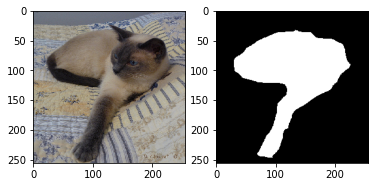

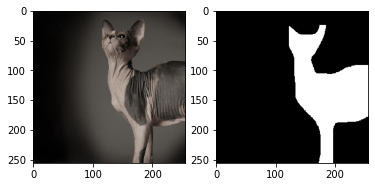

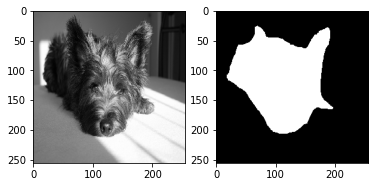

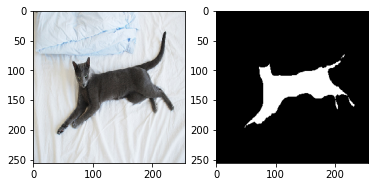

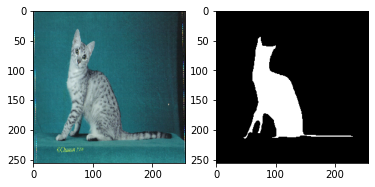

In [83]:
import matplotlib.pyplot as plt

def plotTrainData(x, y):
    for i in range(5):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(batch_x, batch_y)

# U-Net 모델 정의

In [58]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

# 모델 컴파일과 학습

In [75]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(optimizer = 'rmsprop', loss='binary_crossentropy')

model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_216 (Conv2D)             (None, 256, 256, 8)  224         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_217 (Conv2D)             (None, 256, 256, 8)  584         conv2d_216[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_217[0][0]                 
______________________________________________________________________________________

In [60]:
def train_batch_generator(image_generator, label_generator):
    while True:
      yield next(image_generator), next(label_generator)

In [78]:
t = train_batch_generator(img_generator, label_generator)
print(type(t))
print(dir(t))
n = next(t)

<class 'generator'>
['__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__name__', '__ne__', '__new__', '__next__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'close', 'gi_code', 'gi_frame', 'gi_running', 'gi_yieldfrom', 'send', 'throw']


In [81]:
(n0, n1) = n
print(n0.shape)
print(n1.shape)

(64, 256, 256, 3)
(64, 256, 256, 1)


In [62]:

# 학습
hist = model.fit_generator(
    train_batch_generator(img_generator, label_generator), 
    steps_per_epoch=img_generator.samples/64,
    epochs=20, 
    verbose=1)


Epoch 1/20
116/115 [==============================] - 61s 523ms/step - loss: 0.6398
Epoch 2/20
116/115 [==============================] - 53s 460ms/step - loss: 0.5181
Epoch 3/20
116/115 [==============================] - 54s 466ms/step - loss: 0.4874
Epoch 4/20
116/115 [==============================] - 54s 469ms/step - loss: 0.4762
Epoch 5/20
116/115 [==============================] - 54s 466ms/step - loss: 0.4747
Epoch 6/20
116/115 [==============================] - 54s 465ms/step - loss: 0.4732
Epoch 7/20
116/115 [==============================] - 54s 464ms/step - loss: 0.4720
Epoch 8/20
116/115 [==============================] - 54s 462ms/step - loss: 0.4728
Epoch 9/20
116/115 [==============================] - 54s 462ms/step - loss: 0.4698
Epoch 10/20
116/115 [==============================] - 54s 467ms/step - loss: 0.4702
Epoch 11/20
116/115 [==============================] - 54s 468ms/step - loss: 0.4705
Epoch 12/20
116/115 [==============================] - 55s 470ms/step - lo

## 로스 보기

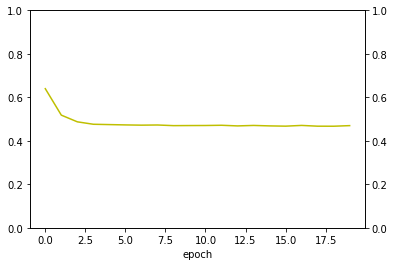

In [65]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_ylim([0.0, 1.0])


loss_ax.set_xlabel('epoch')

plt.show()

## 테스트 결과 보기

In [73]:
import matplotlib.pyplot as plt

def plotPredictions(model, x, y):

  predicted = model.predict(x)
  predicted = (predicted > 0.5).astype(np.uint8)

  for i in range(5):

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("image")
    plt.axis('off')
    plt.imshow(x[i])
    plt.subplot(1,3,2)
    plt.title("label")
    plt.axis('off')
    plt.imshow(y[i].squeeze(), 'gray')
    plt.subplot(1,3,3)
    plt.title("predicted")    
    plt.axis('off')
    plt.imshow(predicted[i].squeeze(), 'gray')
    plt.show()

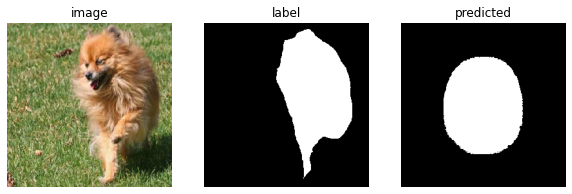

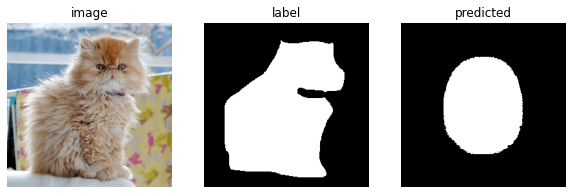

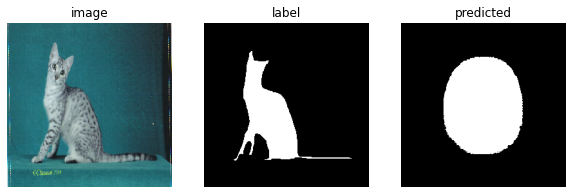

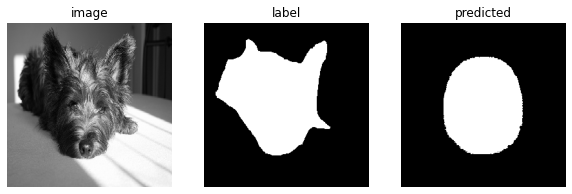

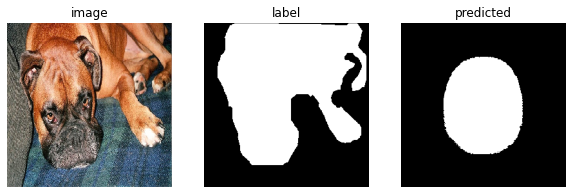

In [74]:
plotPredictions(model, batch_x, batch_y)